# Convolutional Neural Network

## Imports

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from sklearn.model_selection import train_test_split

## Data Paths

In [9]:
train_path = 'archive/seg_train/seg_train/'
test_path = 'archive/seg_test/seg_test/'

## Load Data

In [10]:
image_size = (150, 150) # 150x150 pixels

def load_images(path):
    X = []
    y = []

    folders = sorted(os.listdir(path), key=lambda x: os.path.getmtime(os.path.join(path, x)))

    for i, folder in enumerate(folders):
        for file in os.listdir(os.path.join(path, folder)):
            img = cv2.imread(os.path.join(path, folder, file))
            img = cv2.resize(img, image_size)
            X.append(img)
            y.append(i)

    return np.array(X), np.array(y)

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)

print('Shape of the training data:', X_train.shape)
print('Shape of the test data:', X_test.shape)
print('Number of images in the training data:', X_train.shape[0])
print('Number of images in the test data:', X_test.shape[0])
print('Number of classes:', len(np.unique(y_train)))

Shape of the training data: (14034, 149, 149, 3)
Shape of the test data: (3000, 149, 149, 3)
Number of images in the training data: 14034
Number of images in the test data: 3000
Number of classes: 6


## Number of Classes

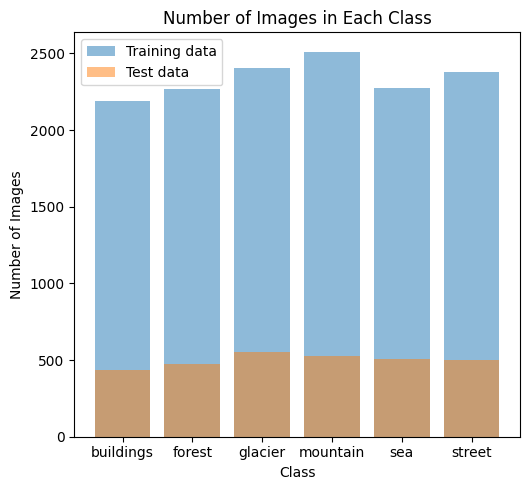

In [11]:
# plot the number if images in each class in the training and test data
labels = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(*np.unique(y_train, return_counts=True), label='Training data', alpha=0.5)
plt.bar(*np.unique(y_test, return_counts=True), label='Test data', alpha=0.5)
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(range(len(labels)), labels.values())  # Set the x-axis tick labels
plt.legend()
plt.tight_layout()
plt.show()


## Show Data

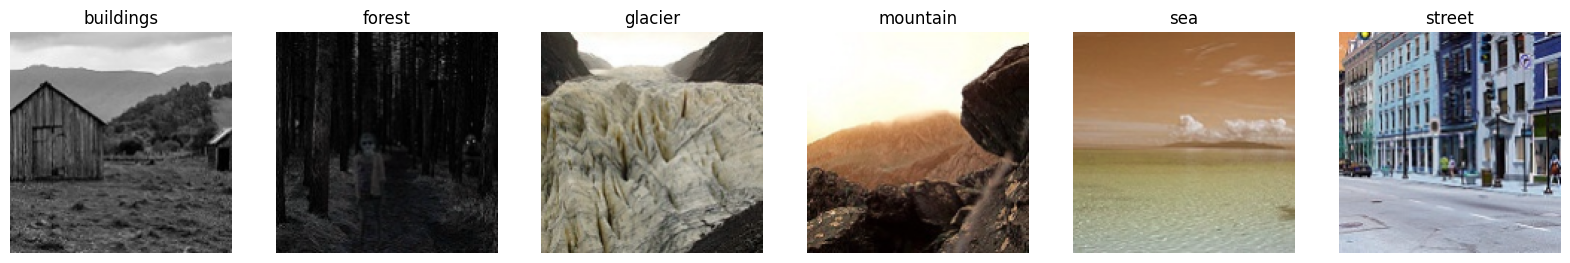

In [12]:
# display some images from the training data per class
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
for i in range(6):
    axes[i].imshow(X_train[y_train == i][0])
    axes[i].set_title(labels[i])
    axes[i].axis('off')
plt.show()

## Split Training and Validation Data

In [13]:
# encode the labels
# encoder = LabelEncoder()
# y_train = encoder.fit_transform(y_train)
# y_test = encoder.transform(y_test)

# # one-hot encode the labels
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

# split the training data into training and validation data
# 80% of the data will be used for training and 20% for validation
# split the data stratified by the labels
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

# print the number of images in each class in the training, validation, and test data
print('Number of images in each class in the training data:', np.unique(y_train, return_counts=True))
print('Number of images in each class in the validation data:', np.unique(y_val, return_counts=True))
print('Number of images in each class in the test data:', np.unique(y_test, return_counts=True))

Number of images in each class in the training data: (array([0, 1, 2, 3, 4, 5]), array([1753, 1817, 1923, 2009, 1819, 1906]))
Number of images in each class in the validation data: (array([0, 1, 2, 3, 4, 5]), array([438, 454, 481, 503, 455, 476]))
Number of images in each class in the test data: (array([0, 1, 2, 3, 4, 5]), array([437, 474, 553, 525, 510, 501]))


: 

## Normalize Data

In [14]:
# # normalize the images
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0